In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/visualize_rois.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py",

In [2]:
%matplotlib notebook

# Test a dataset

# Set responsivity params

In [3]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5
experiment_type = 'gratings'

# Get aggregate data

In [4]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
trace_type = optsE.trace_type
print aggregate_dir

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_inst

/n/coxfs01/julianarhee/aggregate-visual-areas


In [5]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']==experiment_type]

In [6]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


In [311]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [227]:
import shutil
mapdir = os.path.join(aggregate_dir, 'widefield-maps')

In [225]:
all_animals = sdata['animalid'].unique()
all_animals

array(['JC084', 'JC091', 'JC085', 'JC090', 'JC099', 'JC097', 'JC076',
       'JC078', 'JC080', 'JC083'], dtype=object)

In [228]:
for animalid in all_animals:
    try:
        impaths = glob.glob(os.path.join(rootdir, animalid, 'macro_maps', '*', 'overlay_*.png'))
        assert len(impaths) > 0
    except Exception as e:
        try:
            impaths = glob.glob(os.path.join(rootdir, animalid, 'macro_maps', 'overlay_*.png'))
        except Exception as e:
            print("%s: NO IMAGE PATHS")
            continue
    #print('Found %i images.' % len(impaths))
    for impath in impaths:
        fname_new = '%s_%s' % (animalid, os.path.split(impath)[-1])
        shutil.copy(impath, os.path.join(mapdir, fname_new))
        

# Create output dir for analysis


In [7]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [8]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'


# Load aggregate stats

In [9]:
experiment_type = 'blobs'

In [10]:
outdir = os.path.join(aggregate_dir, '%s-tuning' % experiment_type, stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00


In [11]:
aggr_tcourse_dir = os.path.join(aggregate_dir, 'data-stats', 'experiment-objects', experiment_type)
aggr_stats_dir = os.path.join(aggregate_dir, 'data-stats', stats_desc)

if not os.path.exists(aggr_tcourse_dir):
    os.makedirs(aggr_tcourse_dir)
if not os.path.exists(aggr_stats_dir):
    os.makedirs(aggr_stats_dir)

# Visualize all datasets in area

In [12]:
zscore_within = True

zscore_desc = 'zscore-within' if zscore_within else 'raw-values'
print(zscore_desc)

zscore-within


In [13]:
data_id = '%s|%s|%s|%s\n%s|%s' % (experiment_type, fov_type, traceid, trace_type, stats_desc, thresh_str)
print data_id

blobs|zoom2p0x|traces001|corrected
stats-traces001-corrected-dff-nstds-thr-10.00|thr-0.03


# Select datasets - no reps

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [14]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']
also_exclude = ['JC078-2019513', 'JC083-20190512']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

12


In [15]:
dflist=[]
trialdict = {}
for visual_area in ['V1', 'Lm', 'Li']:
    sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, traceid, response_type))
    print("Stats: %s" % os.path.split(sfilename)[-1])
    load_data = True
    allstats = {}
#     try:
#         with open(sfilename, 'rb') as f:
#             allstats = pkl.load(f)
#             #assert 'gdf' in estats
#     except Exception as e:
#         load_data = True
#         allstats = {}

    for skey, estats in allstats.items():
        if '-'.join(skey.split('-')[0:2]) in excluded_sessions:
            continue
            
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()[response_type], 
                                     name='%s_%s_%i' % (visual_area, skey, roi)) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            roi_ixs = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            roi_ixs = meanr.index.tolist()
        rois_plot = [int(k.split('_')[-1]) for k in roi_ixs]
        
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))
        meandf = meanr.loc[roi_ixs]
        
        if zscore_within:
            gm = meandf.mean().mean()
            gs = meandf.std().std()
            meandf = (meandf - gm) / gs
        dflist.append(meandf)
        
        # Save per-trial info
        tdf = pd.concat([pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')[response_type].values,
                     index=estats.gdf.get_group(roi).sort_values(by='trial')['trial'].values,\
                   columns=[roi]) for roi in rois_plot], axis=1)

        trialdict.update({'%s_%s' % (visual_area, skey): tdf})
        
df = pd.concat(dflist, axis=0)


Stats: V1_blobs_traces001-dff.pkl
Plotting 128 of 180 responsive cells.
Plotting 237 of 298 responsive cells.
Plotting 125 of 166 responsive cells.
Plotting 119 of 132 responsive cells.


KeyboardInterrupt: 

In [321]:
trials = {}
for visual_area in visual_areas:
    curr_keys = [k for k in trialdict.keys() if k.split('_')[0]==visual_area]
    print("%s: %i fovs" % (visual_area, len(curr_keys)))
    trials[visual_area] = [trialdict[k] for k in curr_keys]

    

V1: 8 fovs
Lm: 7 fovs
Li: 7 fovs


In [322]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00'

In [323]:

trial_corrs = dict((visual_area, []) for visual_area in visual_areas)

for vi, visual_area in enumerate(visual_areas):
    for ti, tdf in enumerate(trials[visual_area]):
        corr_mat = tdf.corr(method=corr_method)
        trial_corrs[visual_area].append(corr_mat)


<IPython.core.display.Javascript object>


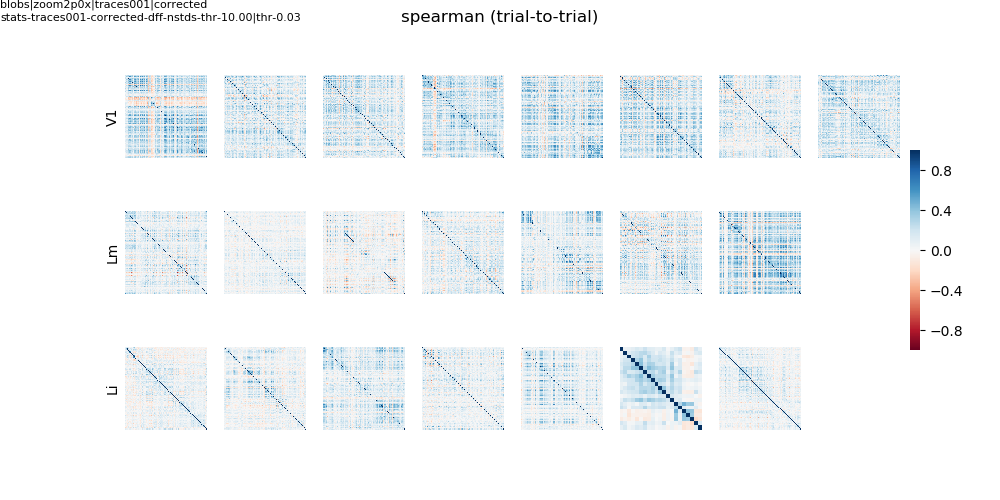

In [324]:
ncols = max([len(v) for k, v in trials.items()])
nrows = len(visual_areas)

fig, axes = pl.subplots(nrows, ncols, figsize=(10, 5))
fig.patch.set_alpha(1)
cbar_ax = fig.add_axes([.91, .3, .01, .4])

i = 0
for vi, visual_area in enumerate(visual_areas):
    for ti, corr_mat in enumerate(trial_corrs[visual_area]):
        ax = axes[vi, ti]
        sns.heatmap(corr_mat, cmap=cmap, vmin=-1, vmax=1, ax=ax, square=True,
                    cbar=i==0, cbar_ax=None if i else cbar_ax)
        ax.set_xticks([]); ax.set_xticklabels([]);
        ax.set_yticks([]); ax.set_yticklabels([]); #('off')
        if ti==0:
            ax.set_ylabel(visual_area)
        i += 1
    for ti in np.arange(ti, ncols):
        axes[vi, ti].axis('off')
        i += 1

fig.suptitle('%s (trial-to-trial)' % corr_method)

label_figure(fig, data_id)
pl.savefig(os.path.join(outdir, 'trial-correlations_by-dataset_%s.png' % thresh_str))

# Calculate average trial corr

In [325]:
avg_tcorrs = {}
for visual_area, corr_mats in trial_corrs.items():
    avg_tcorrs[visual_area] = [np.mean(np.abs(np.tril(c, -1))) for c in corr_mats]
avg_tcorrs

{'Li': [0.04365352322817768,
  0.044618821712001204,
  0.06915971926194656,
  0.046282157897814806,
  0.053743413824843246,
  0.07312408263855635,
  0.04089107398383837],
 'Lm': [0.05800132799726399,
  0.03569645601175006,
  0.04272205971965887,
  0.05773329194416768,
  0.06921227057461071,
  0.07374359869435927,
  0.10926085546614578],
 'V1': [0.09799935446273395,
  0.07178508791472353,
  0.0767830113819402,
  0.09344602794077238,
  0.0963775735055432,
  0.09617412657977674,
  0.06078126966007046,
  0.08424782127966444]}

<IPython.core.display.Javascript object>


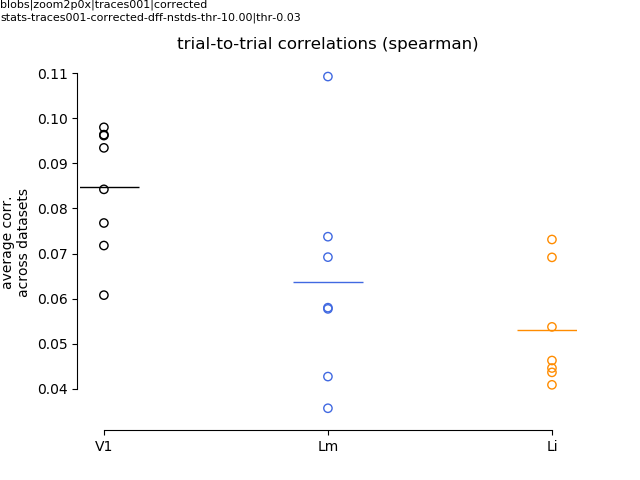

trial-corrs_spearman_TRIL_average_across_fovs_noreps


In [326]:
fig, ax = pl.subplots()
fig.patch.set_alpha(1)
for vi, visual_area in enumerate(visual_areas):
    ax.scatter([vi for _ in range(len(avg_tcorrs[visual_area]))], avg_tcorrs[visual_area], 
               facecolor='none', edgecolor=area_colors[visual_area])
    
    ax.plot(vi, np.mean(avg_tcorrs[visual_area]), marker='_', markersize=50, color=area_colors[visual_area])

sns.despine(trim=True, offset=2)
ax.set_xticks(np.arange(0, len(visual_areas)))
ax.set_xticklabels(visual_areas)
ax.set_ylabel('average corr.\nacross datasets')
ax.set_title('trial-to-trial correlations (%s)' % corr_method)

label_figure(fig, data_id)
figname = 'trial-corrs_%s_TRIL_average_across_fovs_noreps' % corr_method
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname


In [327]:
c1 = avg_tcorrs['V1']
c2 = avg_tcorrs['Lm']
c3 = avg_tcorrs['Li']

In [328]:
# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

((0.8846400380134583, 0.20845630764961243),
 (0.9238530397415161, 0.4999152719974518),
 (0.8335520029067993, 0.08645022660493851))

In [329]:
# Levene variance test  
spstats.levene(c1, c2, c3)

LeveneResult(statistic=0.6087000571139239, pvalue=0.5543305334527009)

In [330]:
F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

F statistic = 6.374 and probability p = 0.008


In [331]:
scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

(22,)
(22,)


In [332]:
import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0107  -0.0131 0.0345 False 
  Li     V1    0.0316   0.0086 0.0547  True 
  Lm     V1    0.0209  -0.0021 0.044  False 
--------------------------------------------


In [333]:
experiment_type

'blobs'

In [119]:
sdf = reformat_morph_values(estats.sdf)


# Correlation bw conditions 
Calculate for each FOV, then get average across FOVs

In [284]:
visual_areas = ['V1', 'Lm', 'Li']
cmap = 'RdBu'

In [285]:
corr_method = 'spearman'


In [286]:
config_labels = ['mp %i, sz %i' % (sdf['morphlevel'][c], sdf['size'][c]) for c in df.columns.tolist()]

KeyError: 'config051'

In [121]:

condcorrs = {}

fig.patch.set_alpha(1)
for visual_area in visual_areas:
    curr_ixs = [s for s in df.index.tolist() if s.split('_')[0] == visual_area]
    tmpd = df.loc[curr_ixs].copy()
    curr_dsets = sorted(np.unique(['_'.join(s.split('_')[1:3]) for s in tmpd.index.tolist()]), key=natural_keys)
    for ds in curr_dsets:
        curr_sesh = [s for s in tmpd.index.tolist() if '_'.join(s.split('_')[1:3])==ds]
        if len(np.where(np.isnan(tmpd.loc[curr_sesh]))[0] > 0):
            print visual_area, ds
        
        dcorr = tmpd.loc[curr_sesh].corr(method=corr_method)
        condcorrs['%s_%s' % (visual_area, ds)] = dcorr
        

corrmats = {}
for visual_area in visual_areas:
    currkeys = sorted([k for k in condcorrs.keys() if k.split('_')[0]==visual_area], key=natural_keys)
    corrmats[visual_area] = np.array([v.values for k, v in condcorrs.items() if k in currkeys])
             

<IPython.core.display.Javascript object>


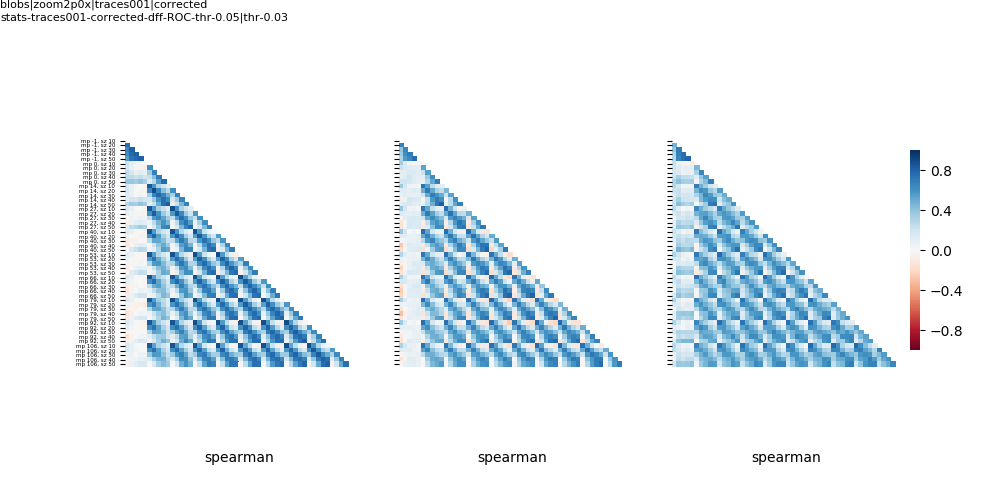

spearman_average_across_fovs_noreps


In [190]:

fig, axes = pl.subplots(1,3, sharex=True, sharey=True, figsize=(10, 5))
fig.patch.set_alpha(1)

cbar_ax = fig.add_axes([.91, .3, .01, .4])

for i, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    corr_matrix = corrmats[visual_area].mean(axis=0)
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    sns.heatmap(corr_matrix, mask=mask, ax=ax, vmin=-1, vmax=1, cmap=cmap, square=True,
               cbar=i==0, cbar_ax=None if i else cbar_ax)

    ax.set_yticks(np.linspace(0.5, nconditions-0.5))
    ax.set_yticklabels(config_labels, fontsize=4)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(corr_method)
    if not i==0:
        ax.set_ylabel('')
        
label_figure(fig, data_id)
figname = '%s_average_across_fovs_noreps' % corr_method
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Average lower tri

In [150]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [161]:
avg_corrs = {}
sem_corrs = {}
for i, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    avg_corrs[visual_area] = [np.mean(np.abs(np.tril(corrmats[visual_area][ci, :, :], -1))) for ci in range(corrmats[visual_area].shape[0])]
    sem_corrs[visual_area] = [spstats.sem(np.abs(np.tril(corrmats[visual_area][ci, :, :], -1))) for ci in range(corrmats[visual_area].shape[0])]



<IPython.core.display.Javascript object>


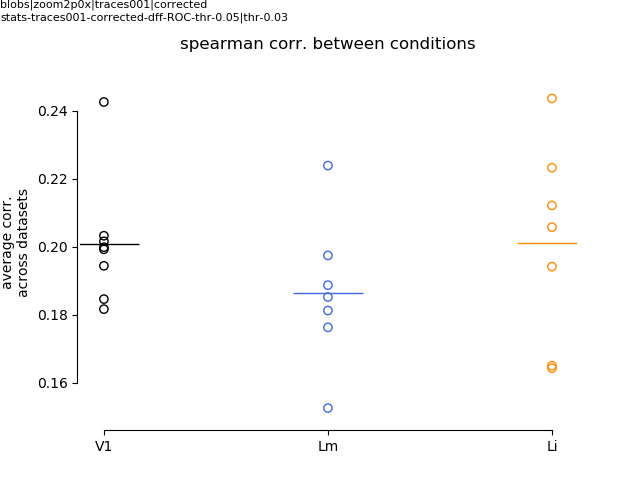

spearman_TRIL_average_across_fovs_noreps


In [192]:
fig, ax = pl.subplots()
fig.patch.set_alpha(1)
for vi, visual_area in enumerate(visual_areas):
    ax.scatter([vi for _ in range(len(avg_corrs[visual_area]))], avg_corrs[visual_area], 
               facecolor='none', edgecolor=area_colors[visual_area])
    
    ax.plot(vi, np.mean(avg_corrs[visual_area]), marker='_', markersize=50, color=area_colors[visual_area])

sns.despine(trim=True, offset=2)
ax.set_xticks(np.arange(0, len(visual_areas)))
ax.set_xticklabels(visual_areas)
ax.set_ylabel('average corr.\nacross datasets')
ax.set_title('%s corr. between conditions' % corr_method)

label_figure(fig, data_id)
figname = '%s_TRIL_average_across_fovs_noreps' % corr_method
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname


<IPython.core.display.Javascript object>


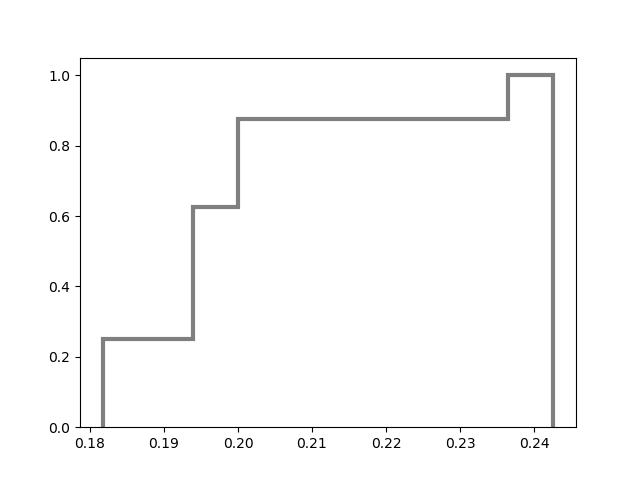

In [159]:
cdf = True
fig, ax = pl.subplots()
for visual_area, acorrs in avg_corrs.items():
    weights = np.ones_like(acorrs)/float(len(acorrs))
    nfovs = corrmats[visual_area].shape[0]
    ax.hist(acorrs, 
            cumulative=cdf,
            label='%s (n=%i fovs)' % (visual_area, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    

# Condition corrs (all datasets)

In [230]:
config_labels = ['mp %i, sz %i' % (sdf['morphlevel'][c], sdf['size'][c]) for c in df.columns.tolist()]

<IPython.core.display.Javascript object>


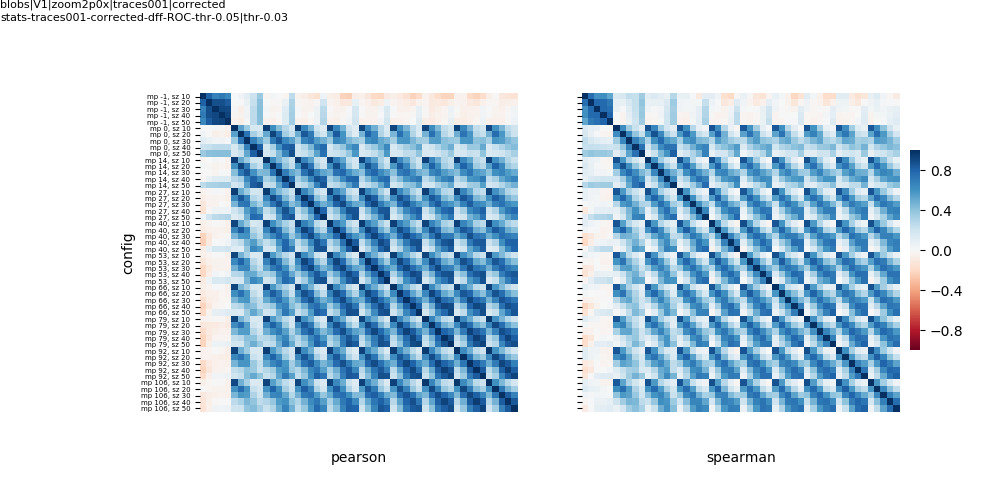

condition-correlations_thr-0.03_raw-values


In [231]:
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
fig.patch.set_alpha(1)
methods = ['pearson', 'spearman']
for i, (ax, corr_method) in enumerate(zip(axes.flat, methods)):
    dfcorr = df.corr(method=corr_method)
    sns.heatmap(dfcorr, ax=ax, vmin=-1, vmax=1, cmap=cmap, square=True,
               cbar=i==0, cbar_ax=None if i else cbar_ax)

    ax.set_yticks(np.linspace(0.5, len(df.columns)-0.5))
    ax.set_yticklabels(config_labels, fontsize=5)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(corr_method)
    if not i==0:
        ax.set_ylabel('')
    
pl.subplots_adjust(left=0.2)
label_figure(fig, data_id)
figname = 'condition-correlations_%s_%s' % (thresh_str, zscore_desc)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Cell-to-cell correlations

In [312]:
corr_method = 'pearson'
cellcoor = df.T.corr(method=corr_method)    

In [313]:
ntotal = df.shape[0]

In [314]:
visual_areas = ['V1', 'Lm', 'Li']
setnames = np.unique(['_'.join(s.split('_')[0:2]) for s in cellcoor.index.unique()])
subsetindices = dict((sname, [i for i, skey in enumerate(cellcoor.index.tolist()) if sname in skey])\
                 for sname in setnames)


print(len(setnames))
setindices = dict((visual_area, [i for i, skey in enumerate(cellcoor.index.tolist()) \
                                         if '%s' % visual_area in skey.split('_')[0]]) for visual_area in visual_areas)


32


In [315]:
for visual_area, s_ixs in setindices.items():
    midp = s_ixs[0] + ((s_ixs[-1] - s_ixs[0])/2.)
    print visual_area, s_ixs[0], s_ixs[-1], midp        

V1 0 1152 576.0
Lm 1153 2392 1772.5
Li 2393 3333 2863.0


<IPython.core.display.Javascript object>


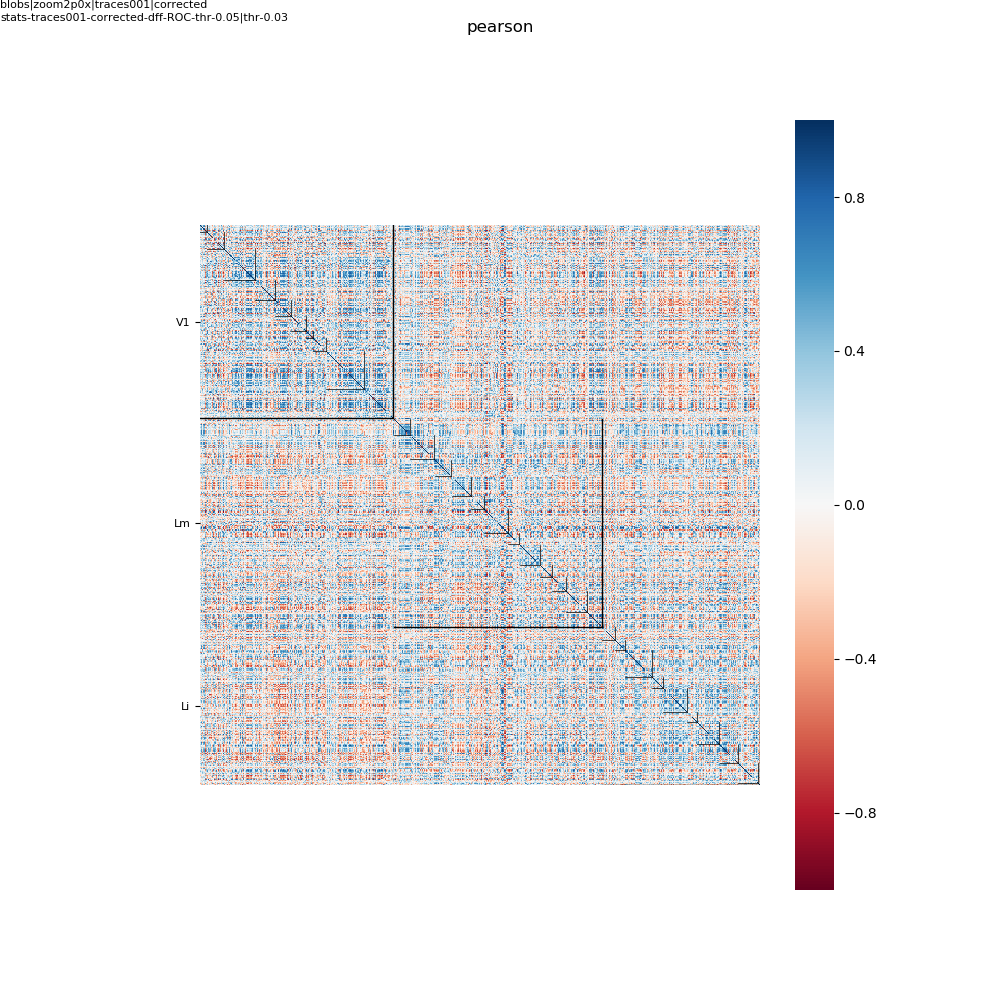

cell-correlations-pearson_thr-0.03_raw-values


In [316]:

fig, ax = pl.subplots(figsize=(10,10))
fig.patch.set_alpha(1)
sns.heatmap(cellcoor, ax=ax, vmin=-1, vmax=1, square=True, cmap=cmap)
fig.suptitle(corr_method)
ax.tick_params(labelsize=6)

yticks=[]; yticklabels=[];
for visual_area, s_ixs in setindices.items():
    ax.axhline(max(s_ixs), xmin=min(s_ixs)/float(ntotal), xmax=max(s_ixs)/float(ntotal), lw=1, c='k')
    ax.axvline(s_ixs[-1], ymin=1.-s_ixs[0]/float(ntotal), ymax=1-s_ixs[-1]/float(ntotal), lw=1, c='k')
    midp = s_ixs[0] + ((s_ixs[-1] - s_ixs[0])/2.)
    yticks.append(midp)
    yticklabels.append(visual_area)

for s_name, s_ixs in subsetindices.items():
    ax.axhline(s_ixs[-1], xmin=s_ixs[0]/float(ntotal), xmax=s_ixs[-1]/float(ntotal), lw=.5, c='k')
    ax.axvline(s_ixs[-1], ymin=1.-s_ixs[0]/float(ntotal), ymax=1-s_ixs[-1]/float(ntotal), lw=.5, c='k')

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=8)
ax.set_xticks([])
ax.set_xticklabels([])

pl.subplots_adjust(left=0.2)


label_figure(fig, data_id)
figname = 'cell-correlations-%s_%s_%s' % (corr_method, thresh_str, zscore_desc)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Cell-cell correlations across datasets

In [233]:
setnames = np.unique([s.split('_')[0] for s in cellcoor.index.unique()])
print(len(setnames))
setindices = dict((sname, [i for i, skey in enumerate(cellcoor.index.tolist()) if sname in skey])\
                 for sname in setnames)


In [234]:
ntotal = df.shape[0]
print(ntotal)

1153


<IPython.core.display.Javascript object>


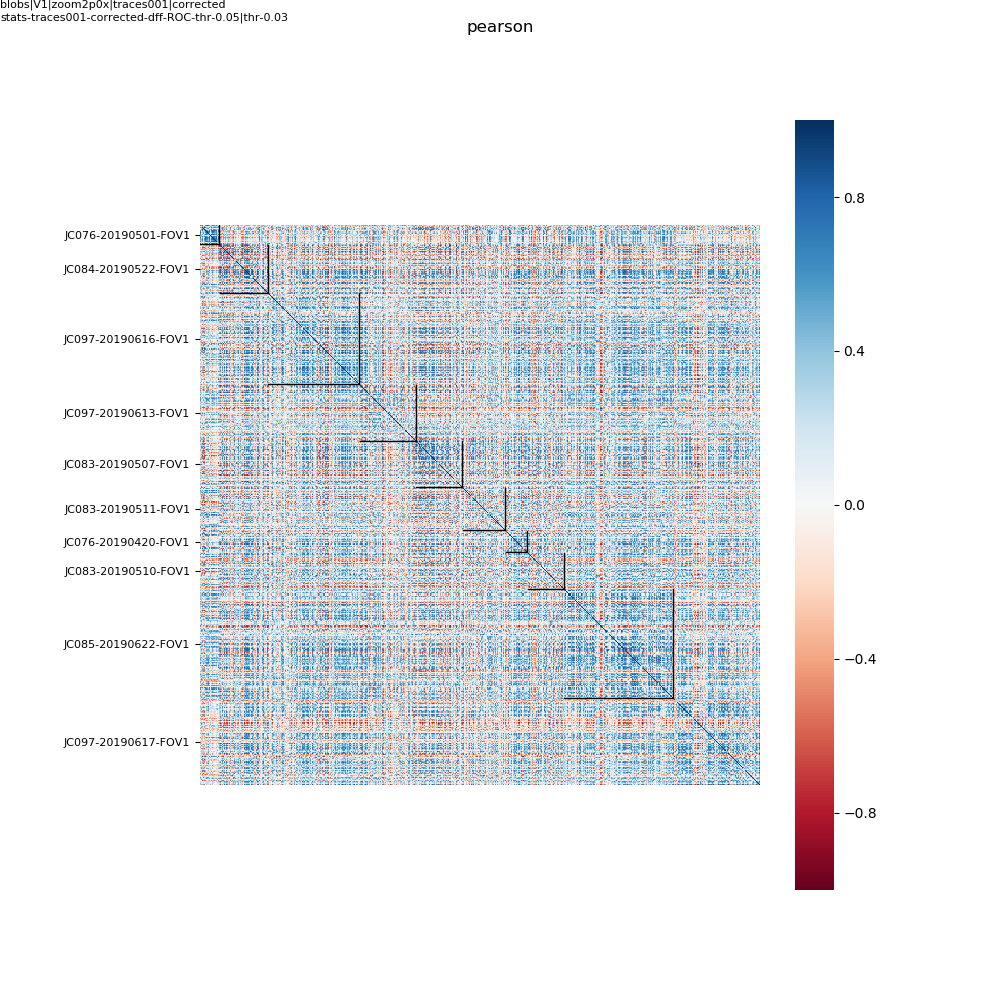

cell-correlations-pearson_thr-0.03_raw-values


<IPython.core.display.Javascript object>


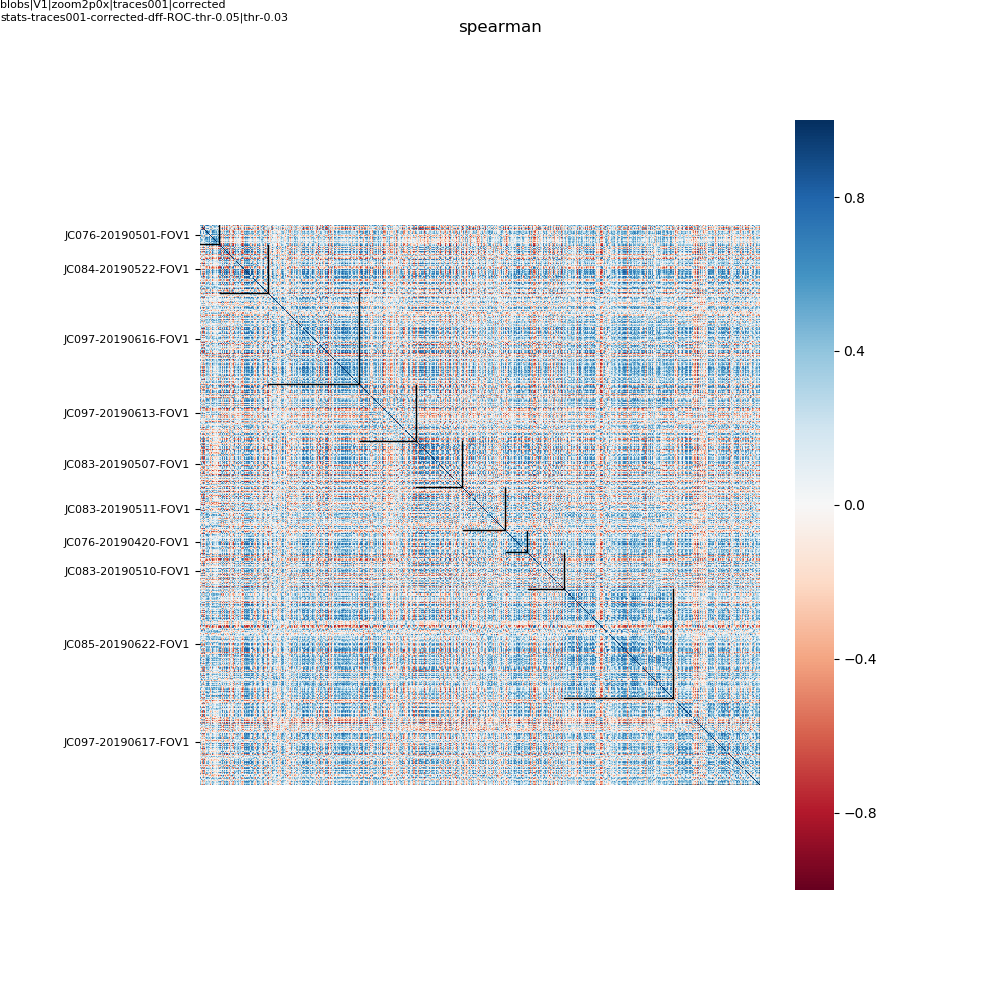

cell-correlations-spearman_thr-0.03_raw-values


In [235]:
cellcoor = df.T.corr()

methods = ['pearson', 'spearman']

for corr_method in methods:
    fig, ax = pl.subplots(figsize=(10,10))
    fig.patch.set_alpha(1)
    cellcoor = df.T.corr(method=corr_method)    
    sns.heatmap(cellcoor, ax=ax, vmin=-1, vmax=1, square=True, cmap=cmap)
    fig.suptitle(corr_method)
    ax.tick_params(labelsize=6)
        
    yticks=[]; yticklabels=[];
    for s_name, s_ixs in setindices.items():
        ax.axhline(s_ixs[-1], xmin=s_ixs[0]/float(ntotal), xmax=s_ixs[-1]/float(ntotal), lw=1, c='k')
        ax.axvline(s_ixs[-1], ymin=1.-s_ixs[0]/float(ntotal), ymax=1-s_ixs[-1]/float(ntotal), lw=1, c='k')
        midp = s_ixs[0] + ((s_ixs[-1] - s_ixs[0])/2.)
        yticks.append(midp)
        yticklabels.append(s_name)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=8)
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.2)


    label_figure(fig, data_id)
    figname = 'cell-correlations-%s_%s_%s' % (corr_method, thresh_str, zscore_desc)
    pl.savefig(os.path.join(outdir, '%s.png' % figname))
    print figname

# Whiten global

In [236]:
grand_mean = df.mean().mean()
grand_std = df.std().std()

In [237]:
df_s = (df - grand_mean) / grand_std

<IPython.core.display.Javascript object>


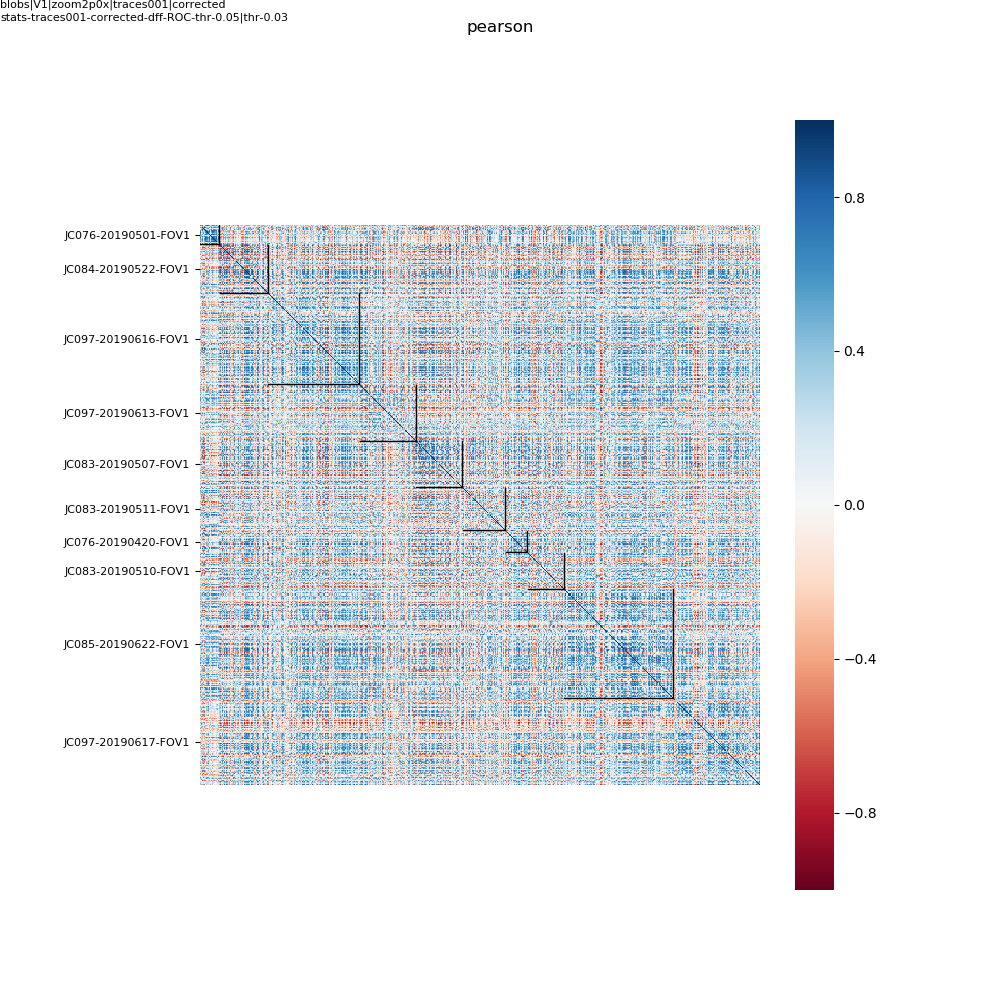

cell-correlations-pearson_thr-0.03_raw-values_global-zscore


<IPython.core.display.Javascript object>


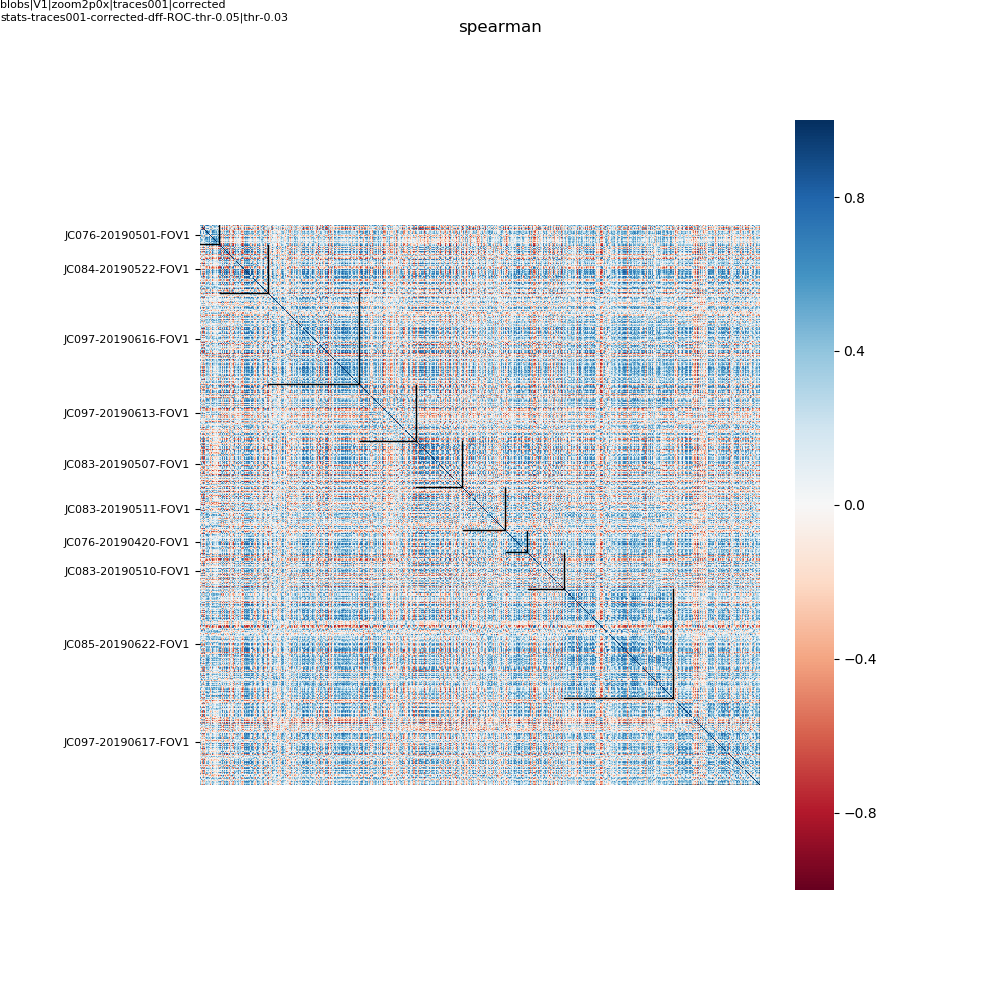

cell-correlations-spearman_thr-0.03_raw-values_global-zscore


In [238]:

methods = ['pearson', 'spearman']

for corr_method in methods:
    fig, ax = pl.subplots(figsize=(10,10))
    fig.patch.set_alpha(1)
    cellcoor = df_s.T.corr(method=corr_method)
    sns.heatmap(cellcoor, ax=ax, vmin=-1, vmax=1, square=True, cmap=cmap)
    fig.suptitle(corr_method)
    ax.tick_params(labelsize=6)
        
    yticks=[]; yticklabels=[];
    for s_name, s_ixs in setindices.items():
        ax.axhline(s_ixs[-1], xmin=s_ixs[0]/float(ntotal), xmax=s_ixs[-1]/float(ntotal), lw=1, c='k')
        ax.axvline(s_ixs[-1], ymin=1.-s_ixs[0]/float(ntotal), ymax=1-s_ixs[-1]/float(ntotal), lw=1, c='k')
        midp = s_ixs[0] + ((s_ixs[-1] - s_ixs[0])/2.)
        yticks.append(midp)
        yticklabels.append(s_name)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=8)
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.2)


    label_figure(fig, data_id)
    figname = 'cell-correlations-%s_%s_%s_global-zscore' % (corr_method, thresh_str, zscore_desc)
    pl.savefig(os.path.join(outdir, '%s.png' % figname))
    print figname

In [107]:
t = pd.DataFrame([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) 
t

0  1  2
0  1  2  3
1  4  5  6
2  7  8  9

In [108]:
t - 5.

0    1    2
0 -4.0 -3.0 -2.0
1 -1.0  0.0  1.0
2  2.0  3.0  4.0

In [109]:
t /5.

0    1    2
0  0.2  0.4  0.6
1  0.8  1.0  1.2
2  1.4  1.6  1.8

In [59]:
from sklearn import decomposition as skd

In [62]:

n_components=2
pca = skd.PCA(whiten=True, random_state=0, n_components=n_components)
X_r = pca.fit_transform(meanr)  
print("Expl. var.:", pca.explained_variance_ratio_) 

('Expl. var.:', array([0.44223827, 0.2258015 ]))


In [65]:
X_r.shape

(178, 2)

<IPython.core.display.Javascript object>


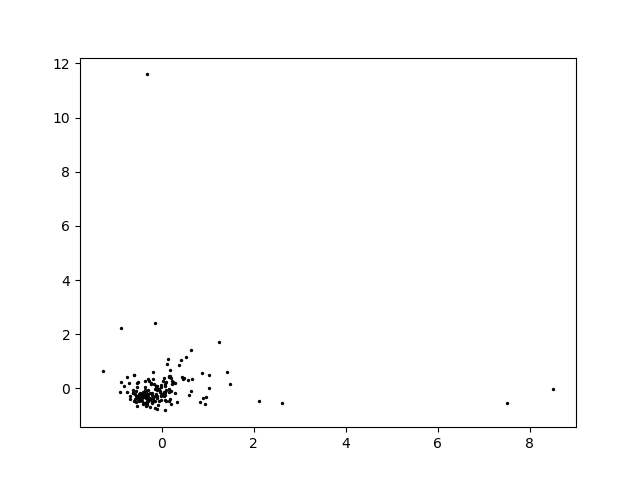

In [64]:
min_x = np.min(X_r[:, 0])
max_x = np.max(X_r[:, 0])

min_y = np.min(X_r[:, 1])
max_y = np.max(X_r[:, 1])

fig, ax = pl.subplots()
ax.scatter(X_r[:, 0], X_r[:, 1], s=2, c='gray', edgecolors=(0, 0, 0))

# Select dataset

In [66]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC099' #'JC059'
session = '20190617' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'
